In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l2
import re

In [12]:
data = pd.read_csv('../raw_data/WELFake_Dataset.csv')
data = data.drop(columns=['Unnamed: 0', 'title'])
data.shape

(72134, 2)

In [13]:
# remove duplicate items
data = data.drop_duplicates(inplace=True)
data.shape

(62720, 2)

In [14]:
# check for null values
data.isnull().sum()

text     1
label    0
dtype: int64

In [15]:
data.dropna(subset=['text'], inplace=True)

In [17]:
# use regex to remove the unimportant info at the begining of each row ('CITY NAME (Reuteurs) -')
def remove_datacity_name(text):
    pattern = r'(?:[A-Z]+(?:[ \/][A-Z]+)* )?\(Reuters\) - '
    return re.sub(pattern, '', text)

In [21]:
# apply regex funciton to each row of the df
data['text'] = data['text'].apply(remove_city_name)
data.head()

,text,label
0,No comment is expected from Barack Obama Membe...,1
1,Did they post their votes for Hillary already?,1
2,"Now, most of the demonstrators gathered last ...",1
3,A dozen politically active pastors came here f...,0
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [23]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def cleaning(sentence):
    
    # Basic cleaning
    sentence = sentence.strip() ## remove whitespaces
    sentence = sentence.lower() ## lowercase 
    sentence = ''.join(char for char in sentence if not char.isdigit()) ## remove numbers
    
    # Advanced cleaning
    for punctuation in string.punctuation:
        sentence = sentence.replace(punctuation, '') ## remove punctuation
    
    tokenized_sentence = word_tokenize(sentence) ## tokenize 
    stop_words = set(stopwords.words('english')) ## define stopwords
    
    tokenized_sentence_cleaned = [ ## remove stopwords
        w for w in tokenized_sentence if not w in stop_words
    ]

    lemmatized = [
        WordNetLemmatizer().lemmatize(word, pos = "v") 
        for word in tokenized_sentence_cleaned
    ]
    
    cleaned_sentence = ' '.join(word for word in lemmatized)
    
    return cleaned_sentence

In [24]:
%%time

data['text_clean'] = data['text'].apply(cleaning)
data

CPU times: user 4min 6s, sys: 4.59 s, total: 4min 11s
Wall time: 4min 12s


,text,label,text_clean
0,No comment is expected from Barack Obama Membe...,1,comment expect barack obama members fyf fukyof...
1,Did they post their votes for Hillary already?,1,post vote hillary already
2,"Now, most of the demonstrators gathered last ...",1,demonstrators gather last night exercise const...
3,A dozen politically active pastors came here f...,0,dozen politically active pastors come private ...
4,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,rs sarmat missile dub satan replace ss fly mil...
...,...,...,...
72127,An email released by WikiLeaks on Sunday appea...,1,email release wikileaks sunday appear show for...
72129,Hackers believed to be working for the Russian...,0,hackers believe work russian government break ...
72130,"You know, because in fantasyland Republicans n...",1,know fantasyland republicans never question ci...
72131,Migrants Refuse To Leave Train At Refugee Camp...,0,migrants refuse leave train refugee camp hunga...


In [32]:
X = data.text_clean
y = data.label

In [33]:
# Perform a 70:30 split for the initial training set and temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Further split the temporary set into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [34]:
%%time
# max_words = 10000  
# max_sequence_length = 500  

# Initialize the tokenizer and fit it on the training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text data to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure uniform length
max_sequence_length = 500

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='pre')
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_sequence_length, padding='pre')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='pre')

CPU times: user 37.8 s, sys: 374 ms, total: 38.1 s
Wall time: 38.3 s


In [35]:
%%time

# Define the RNN model
embedding_dim = 50 
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the zero-padding index
dropout_rate = 0.2
l2_strength = 1e-4

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(2, kernel_regularizer=l2(l2_strength)))  # L2 regularization added
model.add(Dropout(dropout_rate))  # Dropout regularization added
model.add(Dense(1, activation='sigmoid'))

2023-12-06 12:37:12.833515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


CPU times: user 634 ms, sys: 158 ms, total: 792 ms
Wall time: 605 ms


In [36]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
%%time

# Train the model
epochs = 3  

history = model.fit(X_train_padded, y_train, epochs=epochs, validation_data=(X_val_padded, y_val))

Epoch 1/3
1372/1372 [==============================] - 559s 407ms/step - loss: 0.2564 - accuracy: 0.9098 - val_loss: 0.2219 - val_accuracy: 0.9207
Epoch 2/3
1372/1372 [==============================] - 449s 327ms/step - loss: 0.1666 - accuracy: 0.9403 - val_loss: 0.2200 - val_accuracy: 0.9259
Epoch 3/3
1372/1372 [==============================] - 263s 192ms/step - loss: 0.1315 - accuracy: 0.9509 - val_loss: 0.2212 - val_accuracy: 0.9238
CPU times: user 53min 29s, sys: 12min 22s, total: 1h 5min 52s
Wall time: 21min 10s


---

In [48]:
# Initialize the tokenizer and fit it on the training data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [49]:
sequences = tokenizer.texts_to_sequences(data.text_clean)

lengths_of_texts =  [len(text) for text in sequences]

## For length to pad till, we use the average length of all texts 
avg_length_text = int(np.mean(lengths_of_texts))

X_train_pad = pad_sequences(X_train_sequences, maxlen=avg_length_text, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_sequences, maxlen=avg_length_text, padding='pre')
X_test_pad = pad_sequences(X_test_sequences, maxlen=avg_length_text, padding='post', truncating='post')

In [54]:
from keras.callbacks import EarlyStopping

model_3 = Sequential([
    Embedding(input_dim=len(word_index), output_dim=8, input_length=avg_length_text),
    Flatten(),
    Dense(8, activation='relu', kernel_regularizer=l2(0.01)),  # L2 regularization
    Dropout(0.5),  # Adding dropout
    Dense(1, activation='sigmoid')
])

model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Decrease patience, allow restore to best weights during patience
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_3 = model_3.fit(X_train_pad, y_train, epochs=50, batch_size=200, validation_data=(X_val_pad, y_test), callbacks=[early_stopping])

Epoch 1/50
220/220 [==============================] - 4s 15ms/step - loss: 0.5378 - accuracy: 0.7628 - val_loss: 0.9925 - val_accuracy: 0.4919
Epoch 2/50
220/220 [==============================] - 3s 14ms/step - loss: 0.3145 - accuracy: 0.9032 - val_loss: 1.1840 - val_accuracy: 0.4901
Epoch 3/50
220/220 [==============================] - 3s 14ms/step - loss: 0.2513 - accuracy: 0.9222 - val_loss: 1.2822 - val_accuracy: 0.4933
Epoch 4/50
220/220 [==============================] - 3s 14ms/step - loss: 0.2195 - accuracy: 0.9324 - val_loss: 1.4361 - val_accuracy: 0.4913
Epoch 5/50
220/220 [==============================] - 3s 14ms/step - loss: 0.1984 - accuracy: 0.9386 - val_loss: 1.5092 - val_accuracy: 0.4921
Epoch 6/50
220/220 [==============================] - 3s 14ms/step - loss: 0.1815 - accuracy: 0.9439 - val_loss: 1.6126 - val_accuracy: 0.4901


In [55]:
final_train_loss_3 = history_3.history['loss'][-1]
final_train_accuracy_3 = history_3.history['accuracy'][-1]

final_val_loss_3 = history_3.history['val_loss'][-1]
final_val_accuracy_3 = history_3.history['val_accuracy'][-1]

print("Final Training Loss:", final_train_loss_3)
print("Final Training Accuracy:", final_train_accuracy_3)
print("Final Validation Loss:", final_val_loss_3)
print("Final Validation Accuracy:", final_val_accuracy_3)


Final Training Loss: 0.18152989447116852
Final Training Accuracy: 0.943853497505188
Final Validation Loss: 1.6126419305801392
Final Validation Accuracy: 0.49011480808258057


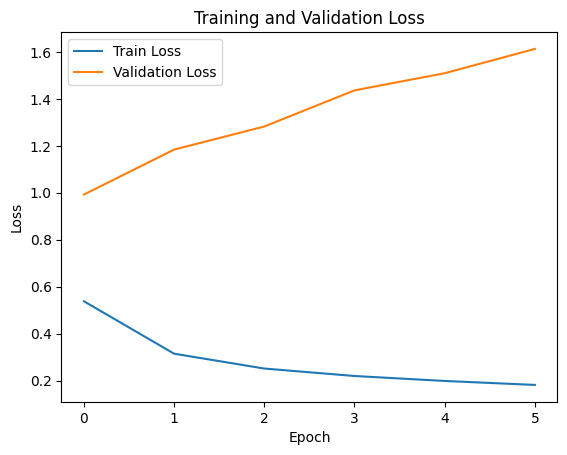

In [56]:
# Plot the training and validation loss
plt.plot(history_3.history['loss'], label='Train Loss')
plt.plot(history_3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()